# Law, Bias, and Algorithms
## Included variable bias (2/2)

In [1]:
# Some initial setup
options(digits = 3)
library(tidyverse)

theme_set(theme_bw())

# Read the data
stop_df <- read_rds("../data/sqf_sample.rds")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Included variable bias

As we discussed last time, one common method for measuring disparities while addressing some of the omitted variable bias concerns is to include _all_ recorded data, that would have been available to the officer at the time of making the decision (to frisk an individual). This is also known as the "kitchen sink" approach.

In [45]:
# Use race_coefs(m) to inspect just the race coefficients of any fitted model m
race_coefs <- function(m) {
    coef(m)[c("suspect_raceblack", "suspect_racehispanic")]
}

feats <- c(
    "suspected_crime",
    "precinct",
    "location_housing",
    "suspect_sex",
    "suspect_age",
    "suspect_height",
    "suspect_weight",
    "suspect_hair",
    "suspect_eye",
    "suspect_build",
    "additional_report",
    "additional_investigation",
    "additional_proximity",
    "additional_evasive",
    "additional_associating",
    "additional_direction",
    "additional_highcrime",
    "additional_time",
    "additional_sights",
    "additional_other",
    "stop_reason_object",
    "stop_reason_desc",
    "stop_reason_casing",
    "stop_reason_lookout",
    "stop_reason_clothing",
    "stop_reason_drugs",
    "stop_reason_furtive",
    "stop_reason_violent",
    "stop_reason_bulge",
    "stop_reason_other",
    "suspect_race"
)

# This creates a formula with a specified left-hand side (frisked), and using 
# all the variables in feats on the right-hand side. 
# Constructing a formula in this way (instead of typing out all the variable names)
# is helpful for constructing multiple models that share a long list of variables in the right-hand side.
kitchen_sink_formula <- reformulate(feats, response = "frisked")

# We are only interested in the race coefficients
ks_model <- glm(kitchen_sink_formula, stop_df, family = binomial)
print(race_coefs(ks_model))

   suspect_raceblack suspect_racehispanic 
               0.191                0.173 


The problems with including variables in measuring disparate impact is that the correlation between a feature and race itself is not necessarily justified.
An obvious example would be something like "skin color", where including skin color in the regression will likely account for observed disparities in race,
but the correlation between skin color and race is unlikely to be justified!
On the other hand, a less obvious example would be an officers suspicion of `cpw`.
While it seems reasonable that an officer would frisk individuals suspected of posessing a weapon more frequently,
the suspicion itself would only be justified if, and to the degree that, it is predictive of achieving the goal of a frisk: recovering weapons.

Blindly including a variable in the regression for treatment fails to take into account this _degree_ of justification, 
often overcompensating for variables that are correlated with race.
This is the problem known as _included variable bias_.

## Risk-adjusted regression

As we briefly discussed, adjusting for any variable (i.e., including it in the regression) is only justified if, and to the degree that, the variable is _predictive of the outcome we are ultimately interested in_ (in this case, recovering a weapon). But the extent to which each variable is justified is rarely clear.

One simple idea for addressing this concern of included variable bias is to control for an explicit measure of **risk**, instead of controling for invididual variables.
Intuitively, we wish to know whether individuals who have _similar risk_ (of carrying a weapon) were treated (frisked) equally.

### Exercise 1: Estimating risk

In order to adjust for risk, we must first estimate it. This is relatively straight forward in the context of frisk decisions in stop-and-frisk, 
because the goal of a frisk is clear---we wish to recover weapons. 
In other words, we want to predict whether a weapon would be found if an individual is frisked. 

* **Step 1**: Split train/test data

When dealing with predictive models, we always want to train our models on one subset of the data, while generating predictions and analyzing a different subset of the data.
This is to make sure that our analysis results are actually generalizable patterns, and not just something that happened to be true in the particular set of data that we collected.

While there are many ways to achieve this, one simple and managable way is to create a new column that indicates whether each row is (randomly) assigned to training or testing. 

- Use `mutate()` to create a new `fold` column in the `stop_df` data, which indicates whether each row is either `"train"` or `"test"`
- (Within the `mutate()` call) randomly assign either `"train"` or `"test"` to the `fold` column 
(Hint: you can use `sample()` to randomly shuffle a vector, and `rep_len()` to repeat the vector `c("train", "test")` up to a certain length)

In [3]:
# Add a fold column to stop_df, which is randomly assigned either "train" or "test"
# WRITE CODE HERE
# START solution
stop_df <- stop_df %>%
    mutate(fold = sample(rep_len(c("train", "test"), n())))
# END solution

* **Step 2**: `filter` the `stop_df` data to those individuals in the `"train"` _who were frisked_. We will call this new data frame `frisked_train_df`

In [4]:
# Subset the stop_df data to train cases where the individual was frisked
# WRITE CODE HERE
# START solution
frisked_train_df <- stop_df %>%
    filter(fold == "train", frisked)
# END solution

* **Step 3**: Using the `frisked_train_df` data, fit a logistic regression to predict whether or not a weapon is found using all features that would reasonably be available to an officer (as listed in `feats` above). Let's call this model `risk_model`. 

Note that we use logistic regression here for simplicity, but in reality, more complex methods for predictive modeling could be employed, with additional measures to avoid overfitting.

In [7]:
# Using the subset of data from Step 2, fit the logistic regression model: found_weapon ~ (all legitimate features in feats) 
# WRITE CODE HERE
# START solution
risk_formula <- reformulate(feats, response = "found_weapon")
risk_model <- glm(risk_formula, data = frisked_train_df, family = binomial)
# END solution

* **Step 4**: Use the `risk_model` from above to generate a column of model estimated risk (we'll name this column `risk`) on the original `stop_df` data. 

_Tip_: Given a `glm` model named `risk_model`, a vector of predictions for `stop_df` can be created with the command `predict(risk_model, stop_df)`.

In [10]:
# Generate a column of predicted risk 
# WRITE CODE HERE
# START solution
stop_df <- stop_df %>%
    mutate(risk = predict(risk_model, .))
# END solution

* **Step 5**: Recall that we (conceptually) split `stop_df` in two folds, with the goal of only using the `test` fold for analysis. 

Create a new data frame called `test_df`, which includes all the data from `stop_df` (including `risk`) which were assigned to the `"test"` fold.

In [11]:
test_df <- 
# WRITE CODE HERE
# START solution
    stop_df %>%
    filter(fold == "test")
# END solution

## Distribution of risk

Now that we have an estimate of risk, we can explore the distribution of risk across race groups.

**Note**: The following sections require and assume the `test_df` data frame, which is the output of the previous exercise. So make sure you've completed it before proceeding.

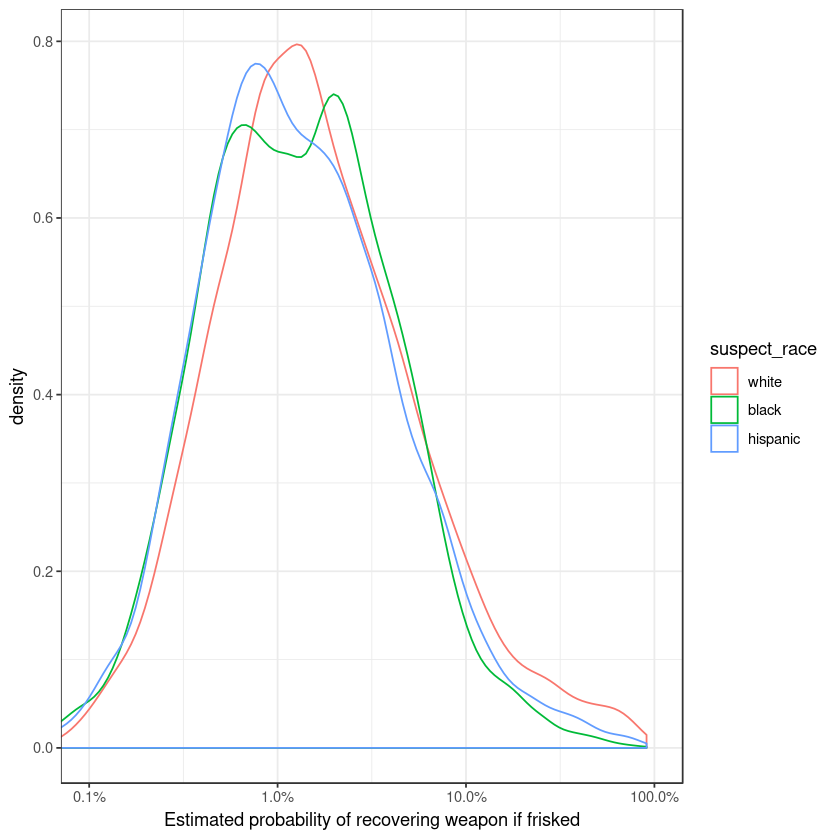

In [40]:
ggplot(test_df, aes(x = binomial()$linkinv(risk))) +
geom_density(aes(color = suspect_race)) +
scale_x_log10("Estimated probability of recovering weapon if frisked",
              labels = scales::percent_format(.1)) +
coord_cartesian(xlim = c(0.001, 1))

### Exercise 2: Distributions of risk

Explore and discuss the distribution of estimated risk. 

In [ ]:
# USE THIS CELL TO WRITE EXPLORATORY CODE

### Exercise 3: Risk-adjusted regression

Given risk estimates, now measure disparate impact of officers' decision to frisk stopped individuals across different race groups.

In [47]:
# WRITE CODE HERE
# START solution
rar_model <- glm(frisked ~ suspect_race + risk, test_df, family = binomial)
print(race_coefs(rar_model))
# END solution

   suspect_raceblack suspect_racehispanic 
               0.762                0.658 


### Exercise 4: Additional considerations

Given the risk-adjusted regression results, what may be some legitimate concerns? 
What are possible justifications for the racial disparities that persist after adjusting for risk? 
How could we revise our model to further account for such possibilities.

In [48]:
# WRITE CODE HERE
# START solution
rar_model <- glm(frisked ~ suspect_race + risk + location_housing, test_df, family = binomial)
print(race_coefs(rar_model))
# END solution

   suspect_raceblack suspect_racehispanic 
               0.803                0.691 
